In [50]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
import cv2 as cv
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras import layers
from keras.optimizers import Adam

In [2]:
data_path = 'seg_train\seg_train'  
data_path_for_test = 'seg_test\seg_test'

In [3]:
image_dimensions = (64, 64)  
def load_and_process_images(path):
    images = []  
    labels = []  
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)  
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)  
                try:
                    image = Image.open(image_path)
                    image = image.resize(image_dimensions)
                    image = image.convert('L') 
                    images.append(np.array(image))
                    labels.append(folder)
                except Exception as e:
                    print("خطأ في قراءة الصورة:", image_path)
                    print(e)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
images, labels = load_and_process_images(data_path)
images = images.astype('float32') / 255

label_to_number = {label: number for number, label in enumerate(np.unique(labels))}
labels = np.array([label_to_number[label] for label in labels])
labels = to_categorical(labels)
images = np.array(images).reshape(14034, 64* 64)

In [5]:
images_test, labels_test = load_and_process_images(data_path_for_test)
images_test = images_test.astype('float32') / 255

label_to_number_test = {label: number for number, label in enumerate(np.unique(labels_test))}
labels_test = np.array([label_to_number_test[label] for label in labels_test])
labels_test = to_categorical(labels_test)
images_test = np.array(images_test).reshape(3000, 64* 64 )

In [6]:
print(images.shape)
print(images_test.shape)

(14034, 4096)
(3000, 4096)


In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
def sigmoid_derivative(x):
    return x * (1 - x)

In [10]:
def ReLU(x):
    return np.maximum(0, x)

In [36]:
from keras.backend import clear_session
clear_session()

In [41]:
class NeuralNetwork:
   
    # constructor for this VERY particular network with 2 layers (plus one for input) # one hidden layer
    
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],64)
        self.weights2   = np.random.rand(64, 32)                  
        self.weights3   = np.random.rand(32, 16) 
        self.weights4   = np.random.rand(16,len(label_to_number)) 
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        self.loss       = []

        # ثوابت RPROP
        self.eta_plus = 1.2
        self.eta_minus = 0.5
        self.max_step = 50
        self.min_step = 1e-6

        # متغيرات RPROP
        self.prev_gradients = [np.zeros(w.shape) for w in [self.weights1, self.weights2, self.weights3, self.weights4]]
        self.step_sizes = [0.1 * np.ones(w.shape) for w in [self.weights1, self.weights2, self.weights3, self.weights4]]


    def calculate_accuracy(self, predictions, targets):
        # تحويل التنبؤات إلى الفئات الحقيقية (أكبر قيمة في كل صف)
        prediction_classes = np.argmax(predictions, axis=1)
        target_classes = np.argmax(targets, axis=1)

        # حساب عدد التنبؤات الصحيحة
        correct_predictions = np.sum(prediction_classes == target_classes)

        # حساب الدقة
        accuracy = correct_predictions / len(targets)
        return accuracy

    # the function that computs the output of the network for some input
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input,self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        self.layer3 = sigmoid(np.dot(self.layer2, self.weights3))
        self.output = sigmoid(np.dot(self.layer3,self.weights4))
        return self.output

    # the backpropagation algorithm 
    def backprop(self, l_rate):
        error_output = 2 * (self.y - self.output) * sigmoid_derivative(self.output)
        d_weights4 = np.dot(self.layer3.T, error_output)

        error_layer3 = np.dot(error_output, self.weights4.T) * sigmoid_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * sigmoid_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * sigmoid_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1)

        self.weights1 += l_rate * d_weights1
        self.weights2 += l_rate * d_weights2
        self.weights3 += l_rate * d_weights3
        self.weights4 += l_rate * d_weights4
        
        self.loss.append(sum(np.power(self.y - self.output,2)))

    def backprop_rprop(self):
        # حساب التدرجات
        error_output = 2 * (self.y - self.output) * sigmoid_derivative(self.output)
        d_weights4 = np.dot(self.layer3.T, error_output)

        error_layer3 = np.dot(error_output, self.weights4.T) * sigmoid_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * sigmoid_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * sigmoid_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1)
            # حساب الخسارة باستخدام MSE
        loss = np.mean(np.square(self.y - self.output))
        self.loss.append(loss)

        # تطبيق RPROP
        for i, (prev_grad, step_size, d_weight, weight) in enumerate(zip(self.prev_gradients, self.step_sizes, [d_weights1, d_weights2, d_weights3, d_weights4], [self.weights1, self.weights2, self.weights3, self.weights4])):
            sign = np.sign(d_weight * prev_grad)
            step_size[sign > 0] *= self.eta_plus
            step_size[sign < 0] *= self.eta_minus
            step_size = np.clip(step_size, self.min_step, self.max_step)

            weight_update = np.sign(d_weight) * step_size
            weight += weight_update

            prev_grad[sign >= 0] = d_weight[sign >= 0]
            self.prev_gradients[i] = prev_grad
            self.step_sizes[i] = step_size


[[9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]
 [9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]
 [9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]
 ...
 [9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]
 [9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]
 [9.12809630e-22 1.70122580e-14 4.54543028e-19 1.60906918e-22
  3.53427295e-36 3.77576188e-25]]


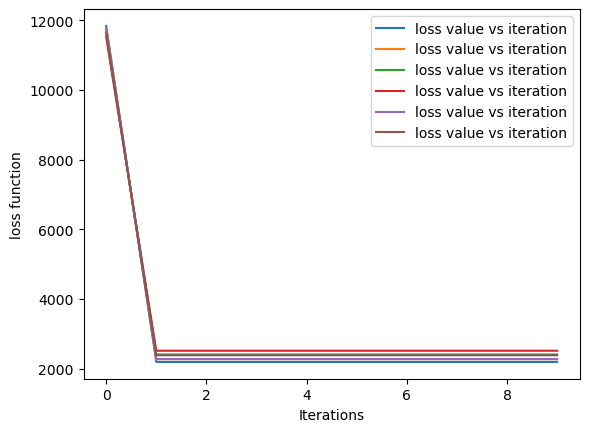

In [31]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    nn.feedforward()
    nn.backprop(l_rate=1)
    iterations.append(i)

print(nn.output)
nn.loss = np.array(nn.loss)

plt.plot(iterations, nn.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [32]:
predictions = nn.feedforward()
acc = nn.calculate_accuracy(predictions, nn.y)
print(f"دقة الشبكة: {acc}")

دقة الشبكة: 0.16182129115006413


[0.8318137341972295, 0.8258914582166199, 0.7863565821376538, 0.5558648580476918, 0.17931382124427772, 0.14145888037795368, 0.15147977114628303, 0.13926601468429559, 0.1431158491583733, 0.13940898683548925]


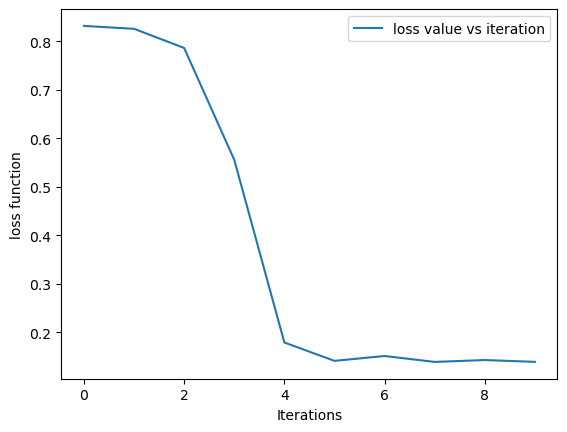

In [43]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    nn.feedforward()
    nn.backprop_rprop()
    iterations.append(i)

print(nn.loss)
nn.loss = np.array(nn.loss)

plt.plot(iterations, nn.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [44]:
predictions = nn.feedforward()
acc = nn.calculate_accuracy(predictions, nn.y)
print(f"دقة الشبكة: {acc}")

دقة الشبكة: 0.17129827561636027


In [47]:
from keras.backend import clear_session
clear_session()

In [48]:
model = Sequential()

model.add(Dense(1024,input_dim=images.shape[1] , activation='relu'))  
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu')) 
model.add(Dense(512, activation='relu')) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu')) 
model.add(Dense(128, activation='relu')) 

model.add(Dense(64, activation='relu'))  
model.add(Dense(64, activation='relu'))  

model.add(Dense(len(label_to_number), activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              4195328   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [49]:
history = model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 28s 75ms/step - loss: 1.6073 - accuracy: 0.2363 - val_loss: 3.0291 - val_accuracy: 0.0000e+00
Epoch 2/10
351/351 [==============================] - 28s 78ms/step - loss: 1.5056 - accuracy: 0.3344 - val_loss: 6.6777 - val_accuracy: 0.0000e+00
Epoch 3/10
351/351 [==============================] - 29s 83ms/step - loss: 1.4082 - accuracy: 0.3779 - val_loss: 7.6946 - val_accuracy: 0.0000e+00
Epoch 4/10
351/351 [==============================] - 29s 84ms/step - loss: 1.3963 - accuracy: 0.3885 - val_loss: 7.7155 - val_accuracy: 0.0000e+00
Epoch 5/10
351/351 [==============================] - 28s 81ms/step - loss: 1.3743 - accuracy: 0.3988 - val_loss: 8.1511 - val_accuracy: 0.0000e+00
Epoch 6/10
351/351 [==============================] - 28s 78ms/step - loss: 1.3576 - accuracy: 0.4137 - val_loss: 7.5671 - val_accuracy: 0.0000e+00
Epoch 7/10
351/351 [==============================] - 27s 76ms/step - loss: 1.3540 - accuracy: 0.4111 - val_loss

In [51]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 8ms/step - loss: 3.0778 - accuracy: 0.3390
Loss: 3.0778164863586426, Accuracy: 0.33899998664855957


In [52]:
history = model.fit(images, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
154/351 [============>.................] - ETA: 14s - loss: 1.3039 - accuracy: 0.4442

KeyboardInterrupt: 

In [14]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 9ms/step - loss: 16.1937 - accuracy: 0.4147
Loss: 16.19366455078125, Accuracy: 0.41466665267944336


In [15]:
history = model.fit(images, labels, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
176/176 [==============================] - 11s 60ms/step - loss: 0.3313 - accuracy: 0.8738 - val_loss: 76.5979 - val_accuracy: 0.0438
Epoch 2/100
176/176 [==============================] - 9s 54ms/step - loss: 0.3194 - accuracy: 0.8782 - val_loss: 82.7197 - val_accuracy: 0.0477
Epoch 3/100
176/176 [==============================] - 11s 62ms/step - loss: 0.3181 - accuracy: 0.8769 - val_loss: 82.1699 - val_accuracy: 0.0388
Epoch 4/100
176/176 [==============================] - 11s 61ms/step - loss: 0.3194 - accuracy: 0.8750 - val_loss: 84.6598 - val_accuracy: 0.0463
Epoch 5/100
176/176 [==============================] - 10s 55ms/step - loss: 0.3103 - accuracy: 0.8812 - val_loss: 83.7325 - val_accuracy: 0.0542
Epoch 6/100
176/176 [==============================] - 8s 47ms/step - loss: 0.3496 - accuracy: 0.8672 - val_loss: 81.8128 - val_accuracy: 0.0463
Epoch 7/100
176/176 [==============================] - 7s 42ms/step - loss: 0.3029 - accuracy: 0.8857 - val_loss: 84.2790 - va

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 9ms/step - loss: 1.6979 - accuracy: 0.3890
Loss: 1.6978572607040405, Accuracy: 0.3889999985694885


In [54]:
history = model.fit(images, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/10
395/395 [==============================] - 11s 28ms/step - loss: 1.2380 - accuracy: 0.5034 - val_loss: 2.3544 - val_accuracy: 0.0812
Epoch 2/10
395/395 [==============================] - 10s 26ms/step - loss: 1.2792 - accuracy: 0.4872 - val_loss: 2.2581 - val_accuracy: 0.1296
Epoch 3/10
264/395 [===================>..........] - ETA: 3s - loss: 1.2256 - accuracy: 0.5134

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [57]:
learning_rate = 0.001  
beta_1 = 0.9           
beta_2 = 0.999        
epsilon = 1e-07        

adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)


In [58]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 32s 85ms/step - loss: 1.3069 - accuracy: 0.4532 - val_loss: 12.8224 - val_accuracy: 0.0000e+00
Epoch 2/10
351/351 [==============================] - 29s 81ms/step - loss: 1.2980 - accuracy: 0.4571 - val_loss: 12.8554 - val_accuracy: 0.0000e+00
Epoch 3/10
351/351 [==============================] - 26s 74ms/step - loss: 1.2952 - accuracy: 0.4568 - val_loss: 13.3590 - val_accuracy: 0.0000e+00
Epoch 4/10
351/351 [==============================] - 23s 64ms/step - loss: 1.2911 - accuracy: 0.4634 - val_loss: 12.5894 - val_accuracy: 0.0000e+00
Epoch 5/10
351/351 [==============================] - 25s 72ms/step - loss: 1.2849 - accuracy: 0.4646 - val_loss: 14.3307 - val_accuracy: 0.0000e+00
Epoch 6/10
351/351 [==============================] - 24s 70ms/step - loss: 1.2873 - accuracy: 0.4625 - val_loss: 14.8395 - val_accuracy: 0.0000e+00
Epoch 7/10
351/351 [==============================] - 25s 70ms/step - loss: 1.2752 - accuracy: 0.4735 - va

In [61]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 8ms/step - loss: 4.4515 - accuracy: 0.3587
Loss: 4.451484680175781, Accuracy: 0.35866665840148926
